* [Exercise 7.1](#Exercise-7.1)
* [Exercise 7.2](#Exercise-7.2)
* [Exercise 7.3](#Exercise-7.3)

## Exercise 7.1.

**Purpose**: Experiment with the Metropolis algorithm as displayed in Figure 7.4.

Python version of `BernMetrop.R`

In [1]:
import numpy as np
from scipy.stats import beta as betad

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from dbda2e_utils import plotPost

In [2]:
# Specify the data, to be used in the likelihood function.
myData = np.concatenate((np.repeat(0,6), np.repeat(1,14)))
# myData = [] # Exercicse 7.3
# myData = [0,1,1] # Exercicse 7.3

In [3]:
# Define the Bernoulli likelihood function, p(D|theta).
def likelihood(theta, data):
    z = sum(data)
    N = len(data)
    
    pDataGivenTheta = theta**z * (1-theta)**(N-z)
    
    # The theta values passed into this function are generated at random,
    # and therefore might be inadvertently greater than 1 or less than 0.
    # The likelihood for theta > 1 or for theta < 0 is zero:
    if np.isscalar(theta):
        if (theta > 1) or (theta < 0):
            pDataGivenTheta = 0.0
    else:
        pDataGivenTheta[(theta > 1) | (theta < 0)] = 0
    return pDataGivenTheta

# Define the prior density function. 
def prior(theta):
    pTheta = betad.pdf(theta, 1 ,1)
    # pTheta = (np.cos(4*np.pi*theta) + 1) ** 2 / 1.5 # Exercicse 7.3
    
    # The theta values passed into this function are generated at random,
    # and therefore might be inadvertently greater than 1 or less than 0.
    # The prior for theta > 1 or for theta < 0 is zero:
    if np.isscalar(theta):
        if (theta > 1) or (theta < 0):
            pTheta = 0.0
    else:
        pTheta[(theta > 1) | (theta < 0)] = 0
    return pTheta

# Define the relative probability of the target distribution, 
# as a function of vector theta. For our application, this
# target distribution is the unnormalized posterior distribution.
def targetRelProb(theta, data):
    targetRelProb =  likelihood(theta, data) * prior(theta)
    return targetRelProb

In [4]:
# Specify standard deviation of proposal distribution:
proposalSD = [0.02, 0.2, 2.0][1]

In [5]:
# Specify the length of the trajectory, i.e., the number of jumps to try:
trajLength = 50000 # arbitrary large number
# Initialize the vector that will store the results:
trajectory = np.zeros((trajLength,))
# Specify where to start the trajectory:
trajectory[0] = 0.01 # arbitrary value
# trajectory[0] = 0.99 # Exercicse 7.3

# Specify the burn-in period:
burnIn = int(np.ceil(0.0 * trajLength)) # arbitrary number, less than trajLength
# Initialize accepted, rejected counters, just to monitor performance:
nAccepted = 0
nRejected = 0

# Now generate the random walk. The 't' index is time or trial in the walk.
# Specify seed to reproduce same random walk:
np.random.seed(47405)

for t in range(trajLength-1):
    currentPosition = trajectory[t]
    # Use the proposal distribution to generate a proposed jump.
    proposedJump = np.random.normal(loc=0.0, scale=proposalSD)
    
    # Compute the probability of accepting the proposed jump.
    pratio = targetRelProb(currentPosition + proposedJump, myData) / targetRelProb(currentPosition, myData)
    probAccept = min(1.0, pratio)
    
    # Generate a random uniform value from the interval [0,1] to
    # decide whether or not to accept the proposed jump.
    if np.random.uniform() < probAccept:
        trajectory[t+1] = currentPosition + proposedJump        
        if t > burnIn:
            nAccepted += 1
    else:
        # reject the proposed jump, stay at current position
        trajectory[t+1] = currentPosition
        # increment the rejected counter, just to monitor performance
        if t > burnIn:
            nRejected += 1
            
# Extract the post-burnIn portion of the trajectory.
acceptedTraj = trajectory[(burnIn+1): len(trajectory)]

# End of Metropolis algorithm.

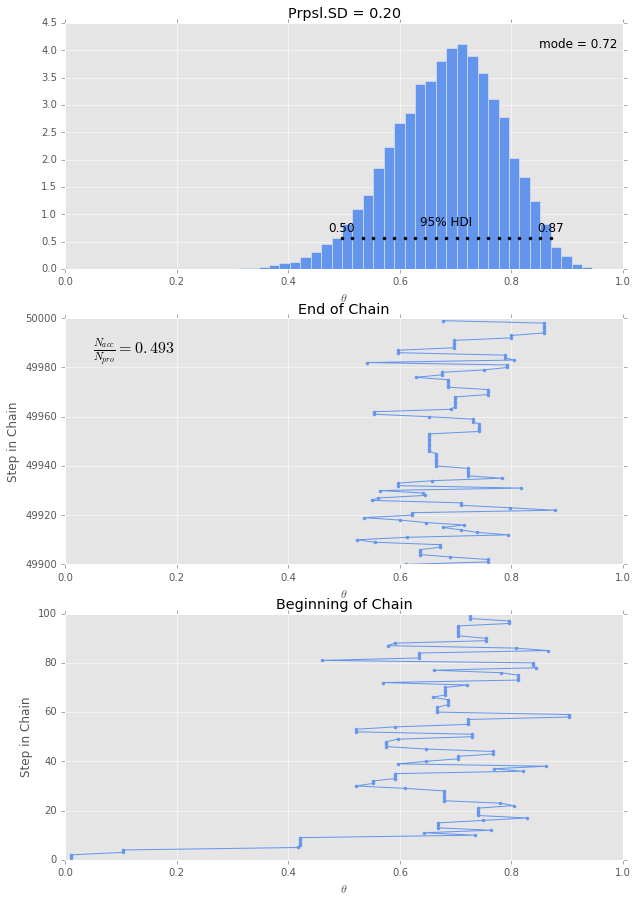

In [6]:
f, axs = plt.subplots(3,1,figsize=(10,15))

title = 'Prpsl.SD = %.2f' % proposalSD
plotPost(acceptedTraj, axs[0], title)

# Trajectory, a.k.a. trace plot, end of chain:
idxToPlot = range((trajLength-100), trajLength)
axs[1].plot(trajectory[idxToPlot] , idxToPlot, marker='.', color='cornflowerblue')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_title('End of Chain')
axs[1].set_ylabel('Step in Chain')
axs[1].set_xlabel(r'$\theta$')

acc_ratio_text = r'$\frac{N_{acc}}{N_{pro}} = %.3f$' % (nAccepted/len(acceptedTraj))
axs[1].annotate(acc_ratio_text, xy=(0.05, 0.85), xycoords='axes fraction', fontsize=16)

# Trajectory, a.k.a. trace plot, beginning of chain:
idxToPlot = range(100)
axs[2].plot(trajectory[idxToPlot] , idxToPlot, marker='.', color='cornflowerblue')
axs[2].set_xlim([0.0, 1.0])
axs[2].set_title('Beginning of Chain')
axs[2].set_ylabel('Step in Chain')
axs[2].set_xlabel(r'$\theta$')

plt.show()

## Exercise 7.2

**Purpose**: To explore the autocorrelation function in Figure 7.12.

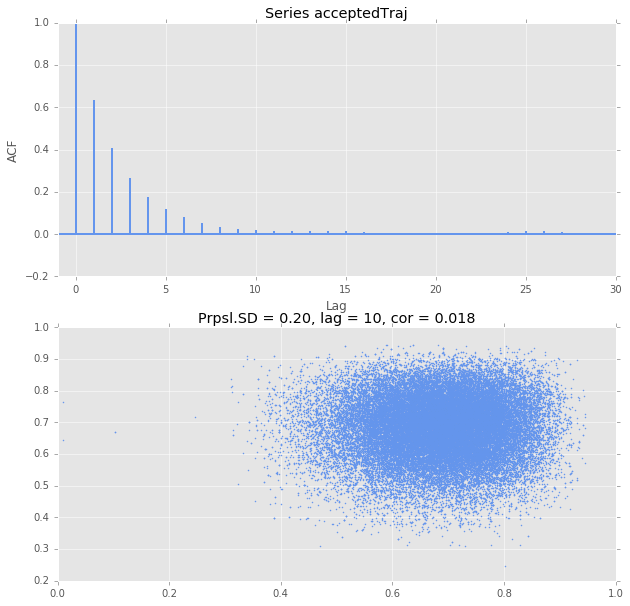

In [7]:
f, axs = plt.subplots(2,1,figsize=(10,10))

maxlags = 60
axs[0].acorr(acceptedTraj - acceptedTraj.mean(), maxlags=maxlags, color='cornflowerblue', linewidth=2.0)
axs[0].set_xlim([-1, maxlags/2])
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].set_title('Series acceptedTraj')

Len = len(acceptedTraj)
Lag = 10

trajHead = acceptedTraj[0:(Len-Lag)]
trajTail = acceptedTraj[Lag:Len]

axs[1].plot(trajHead , trajTail, '.', markersize=2, color='cornflowerblue')
title = 'Prpsl.SD = %.2f, lag = %d, cor = %.3f' % (proposalSD, Lag, np.corrcoef(trajHead, trajTail)[0,1])
axs[1].set_title(title)

plt.show()

## Exercise 7.3

**Purpose**: Using a multimodal prior with the Metropolis algorithm, and seeing how chains can transition across modes or get stuck within them.

### Part B

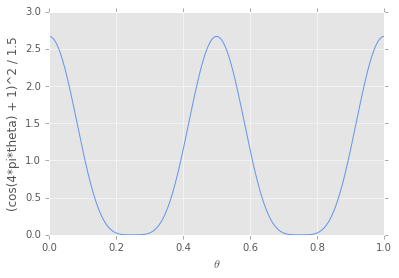

In [8]:
theta = np.linspace(0, 1, num=501)

pTheta = (np.cos(4*np.pi*theta) + 1) ** 2 / 1.5

plt.plot(theta, pTheta, color='cornflowerblue')
plt.xlabel(r'$\theta$')
plt.ylabel('(cos(4*pi*theta) + 1)^2 / 1.5')
plt.show()

### Part C, D, E, F

Re-run [Exercise 7.1](#Exercise-7.1) with the required changes from each part